# Main Objective of our study

Analyze and characterize the nature of developer interactions with ChatGPT.

## Imports and utilities 

First, we defined all common imports and functions used across the code.  
Note: conversations snapshots are available on [DevGPT repository](https://github.com/NAIST-SE/DevGPT).

In [2]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

%matplotlib inline

In [16]:
snapshots = []

def read_json_file(file_path):
    print(f"\tReading file: {file_path}")
    with open(file_path, "r", encoding="utf-8") as file:
        return json.load(file)

def calculate_average(data):
    return sum(data) / len(data)

def format_num(number): 
    return f"{number:,}"

def print_new_line():
    print("\n")
    
def get_snapshots():
    if len(snapshots) > 0:
        print("Returning existing snapshots")
        return snapshots

    print("Returning snapshots from OS")
    for root, _, files in os.walk("../snapshots"):
        for file in files:
            if file.endswith(".json"):
                file_path = os.path.join(root, file)
                snapshots.append(read_json_file(file_path))
    
    return snapshots
    
def draw_pie_chart(sizes, labels, title):
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct=lambda p: '{:,.0f}\n({:.1f}%)'.format(p * sum(sizes) / 100, p))
    ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    ax.set_title(f"{title}\n")
    plt.show()

def draw_simple_bar_chart(xLabel, yLabel, title):
    data = {'C':20, 'C++':15, 'Java':30, 'Python':35}

    courses = list(data.keys())
    values = list(data.values())
    
    fig = plt.figure(figsize = (10, 5))
    
    # creating the bar plot
    plt.bar(courses, values, color = '#7173a9', width = 0.4)
    
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(title)
    plt.show()

## Research Question 1

What types of issues (bugs, feature requests, theoretical questions) do developers most commonly present to ChatGPT? 

## Approach 1: Simple Issues Categorization

In this approach, we fetch the prompts/answers and find simple keywords inside of them to perform simple categorizations.

In [4]:
def categorize_conversation(prompt, answer):
    prompt = prompt.lower()
    answer = answer.lower()

    if "bug" in prompt or "error" in answer:
        category = "Bug"
    elif "feature" in prompt or "implement" in answer:
        category = "Feature Request"
    elif "how to" in prompt or "why" in answer:
        category = "Theoretical Question"
    else:
        category = "Other"

    return category


def process_json_files_rq1_simple():
    categories_count = {
        "Bug": 0,
        "Feature Request": 0,
        "Theoretical Question": 0,
        "Other": 0,
    }

    for data in get_snapshots():
        for source in data.get("Sources", []):
            chatgpt_sharing = source.get("ChatgptSharing", [])
            for sharing in chatgpt_sharing:
                for conversation in sharing.get("Conversations", []):
                    prompt = conversation.get("Prompt", "")
                    answer = conversation.get("Answer", "")
                    category = categorize_conversation(prompt, answer)
                    categories_count[category] += 1

    return categories_count


print("\nStarting analysis...")
result_rq1_simple = process_json_files_rq1_simple()
print("\nAnalysis completed.\n")


Starting analysis...
Returning snapshots from OS
	Reading file: ../snapshots\snapshot_20230727\20230727_195816_hn_sharings.json
	Reading file: ../snapshots\snapshot_20230727\20230727_195927_pr_sharings.json
	Reading file: ../snapshots\snapshot_20230727\20230727_195941_issue_sharings.json
	Reading file: ../snapshots\snapshot_20230727\20230727_195954_discussion_sharings.json
	Reading file: ../snapshots\snapshot_20230727\20230727_200003_commit_sharings.json
	Reading file: ../snapshots\snapshot_20230727\20230727_200102_file_sharings.json
	Reading file: ../snapshots\snapshot_20230803\20230803_093947_pr_sharings.json
	Reading file: ../snapshots\snapshot_20230803\20230803_094705_issue_sharings.json
	Reading file: ../snapshots\snapshot_20230803\20230803_094811_discussion_sharings.json
	Reading file: ../snapshots\snapshot_20230803\20230803_095317_commit_sharings.json
	Reading file: ../snapshots\snapshot_20230803\20230803_103605_file_sharings.json
	Reading file: ../snapshots\snapshot_20230803\2

### RQ1 Results: Simple Issues Categorization


Results:
	Total conversations: 153,556
	Bug: 15,164
	Feature Request: 14,719
	Theoretical Question: 4,487
	Other: 119,186




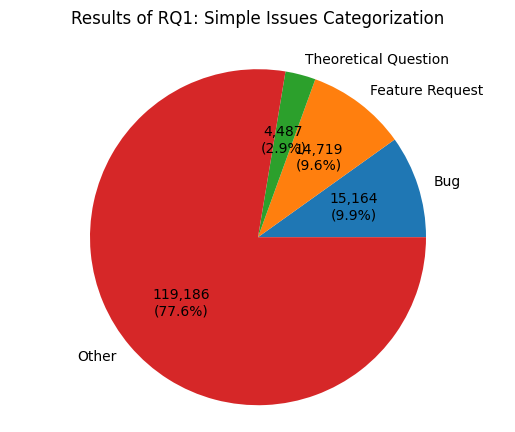

In [5]:
print("\nResults:")

print("\tTotal conversations:", format_num(sum(result_rq1_simple.values())))

for category, count in result_rq1_simple.items():
    print(f"\t{category}: {format_num(count)}")

print_new_line()

draw_pie_chart(
    result_rq1_simple.values(), 
    result_rq1_simple.keys(), 
    "Results of RQ1: Simple Issues Categorization"
)

## Approach 2: Issues categorization via Trained Model

In this approach, we refer to Machine Learning techniques to train a model from a dataset. Thus, we are able to predict and categorize each prompts/questions from a conversation into different issue categories.

In [6]:
vectorizer = TfidfVectorizer(max_features=1000)
model = MultinomialNB()

def train_and_validate_model():
    print("Training model...")
    
    df = pd.read_csv("training_set.csv")
    X_train, X_test, y_train, y_test  = train_test_split(
        df["text"], df["label"], test_size=0.2, random_state=42
    )
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    model.fit(X_train_tfidf, y_train)
    
    print("Training model complete.\n")
    validate_model(y_test, X_test_tfidf)
    

def validate_model(y_test, X_test_tfidf):
    
    print("Validating model.")

    y_pred = model.predict(X_test_tfidf)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print the metrics
    print(f"\tAccuracy: {accuracy:.2f}")
    print(f"\tPrecision: {precision:.2f}")
    print(f"\tRecall: {recall:.2f}")
    print(f"\tF1 Score: {f1:.2f}")    
    
    print("Model validation complete.\n")


def combined_categorization(prompt, answer, model, vectorizer):
    combined_text = prompt + " " + answer
    transformed_text = vectorizer.transform([combined_text])
    return model.predict(transformed_text)[0]


def process_json_files_rq1_model(model, vectorizer):
    categories_count = {
        "Bug": 0,
        "Feature Request": 0,
        "Theoretical Question": 0,
        "Other": 0,
    }
    results = []

    for data in get_snapshots():
        for source in data.get("Sources", []):
            chatgpt_sharing = source.get("ChatgptSharing", [])
            for sharing in chatgpt_sharing:
                for conversation in sharing.get("Conversations", []):
                    prompt = conversation.get("Prompt", "")
                    answer = conversation.get("Answer", "")
                    category = combined_categorization(
                        prompt, answer, model, vectorizer
                    )
                    categories_count[category] += 1

                    # Only add to results if category is not 'Other'
                    if category != "Other":
                        results.append(
                            {
                                "prompt": prompt,
                                "answer": answer,
                                "category": category,
                            }
                        )

    return categories_count, results


print_new_line()
train_and_validate_model()

print("Starting analysis...")
model_categories_count, model_categorized_results = process_json_files_rq1_model(model, vectorizer)
print("\nAnalysis completed.\n")



Training model...
Training model complete.

Validating model.
	Accuracy: 0.73
	Precision: 0.73
	Recall: 0.73
	F1 Score: 0.73
Model validation complete.

Starting analysis...
Returning existing snapshots

Analysis completed.



### RQ1 Results: Issues Categorization via Trained Model


Results:
	Total conversations: 153,556
	Bug: 29,792
	Feature Request: 4,942
	Theoretical Question: 87,764
	Other: 31,058




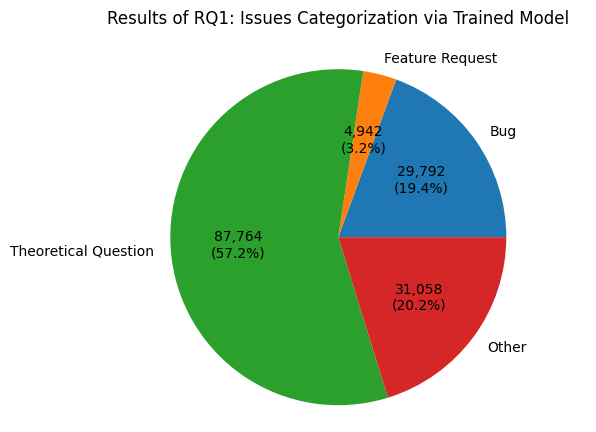

In [7]:
print("\nResults:")

print("\tTotal conversations:", format_num(sum(model_categories_count.values())))

for category, count in model_categories_count.items():
    print(f"\t{category}: {format_num(count)}")

print_new_line()

draw_pie_chart(
    model_categories_count.values(), 
    model_categories_count.keys(), 
    "Results of RQ1: Issues Categorization via Trained Model"
)

## Research Question 2

What is the typical structure of conversations between developers and ChatGPT?   
How many turns does it take on average to reach a conclusion?

In [8]:
def process_json_files_rq2():
    structure = {
        "NumberOfPrompts": [],
        "TokensOfPrompts": [],
        "TokensOfAnswers": [],
        "ListOfCode": 0,
        "TotalConversations": 0,
    }
  
    for data in get_snapshots():
        for source in data.get("Sources", []):
            chatgpt_sharing = source.get("ChatgptSharing", [])
            for sharing in chatgpt_sharing:
                
                number_of_prompts = sharing.get("NumberOfPrompts")
                if number_of_prompts is not None or "":
                    structure["NumberOfPrompts"].append(number_of_prompts)

                number_of_tokens_per_prompts = sharing.get("TokensOfPrompts")
                if number_of_tokens_per_prompts is not None or "":
                    structure["TokensOfPrompts"].append(
                        number_of_tokens_per_prompts
                    )

                number_of_tokens_per_answers = sharing.get("TokensOfAnswers")
                if number_of_tokens_per_answers is not None or "":
                    structure["TokensOfAnswers"].append(
                        number_of_tokens_per_answers
                    )

                # Get number of conversations having code
                for conversation in sharing.get("Conversations", []):
                    structure["TotalConversations"] += 1
                    list_of_code = conversation.get("ListOfCode", [])
                    if len(list_of_code) > 0:
                        structure["ListOfCode"] += 1

    return structure


print("\nStarting analysis...")
structure_results = process_json_files_rq2()
print("\nAnalysis completed.\n")


Starting analysis...
Returning existing snapshots

Analysis completed.



### RQ2 Results: Structure and statistics of conversations


Results:
	Average number of prompts or turns in a conversations:  6.871345029239766
	Average number of words in a question of a conversation:  1,053.3134590863124
	Average number of words in an answer of a conversation:  2,261.201644462032


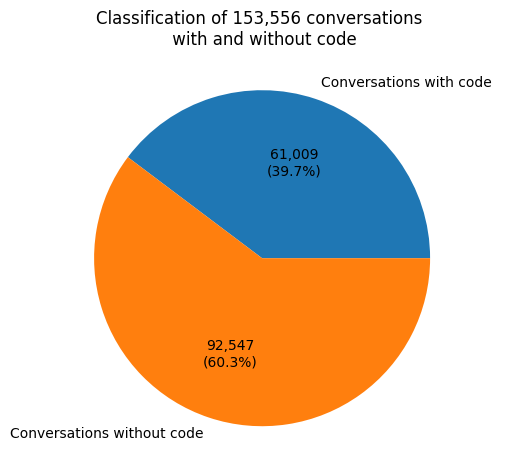

In [22]:
print("\nResults:")

nbOfConversations = structure_results["TotalConversations"]
linesOfCodes = structure_results["ListOfCode"]

print(
    "\tAverage number of prompts or turns in a conversations: ",
    format_num(calculate_average(structure_results["NumberOfPrompts"])),
)

print(
    "\tAverage number of words in a question of a conversation: ",
    format_num(calculate_average(structure_results["TokensOfPrompts"])),
)

print(
    "\tAverage number of words in an answer of a conversation: ",
    format_num(calculate_average(structure_results["TokensOfAnswers"])),
)

draw_pie_chart(
    [linesOfCodes, nbOfConversations - linesOfCodes], 
    ["Conversations with code", "Conversations without code"], 
    f"Classification of {format_num(nbOfConversations)} conversations \n with and without code"
)